<a href="https://colab.research.google.com/github/DipeshChothwe/PRODUCT-REVIEW-SUMMARIZATION/blob/edited-version1/Summary_words_from_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading the data**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [70]:
reviews = pd.read_json('/content/drive/My Drive/NLP/Cell_Phones_and_Accessories.json')


# **Understanding the data**

In [24]:
reviews.head(1)

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
0,5,True,"09 1, 2015",B009XD5TPQ,None,Sunny Zoeller,Bought it for my husband. He's very happy with it,He's very happy with,1441065600,None,None


In [25]:
reviews.describe()

,Rating,Review_timestamp
count,760450.000000,7.604500e+05
mean,4.221357,1.440417e+09
std,1.232186,4.563251e+07
min,1.000000,1.035331e+09
25%,4.000000,1.416355e+09
50%,5.000000,1.444349e+09
75%,5.000000,1.470442e+09
max,5.000000,1.538438e+09


In [26]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760450 entries, 0 to 760449
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Rating            760450 non-null  int64 
 1   Rev_verify        760450 non-null  bool  
 2   Review_Date       760450 non-null  object
 3   IC                760450 non-null  object
 4   Prod_meta         407826 non-null  object
 5   Reviewer_Name     760359 non-null  object
 6   Review            759920 non-null  object
 7   Rev_summ          760095 non-null  object
 8   Review_timestamp  760450 non-null  int64 
 9   Useful            62200 non-null   object
 10  Prod_img          18194 non-null   object
dtypes: bool(1), int64(2), object(8)
memory usage: 64.5+ MB


In [28]:
i = reviews
i.groupby('IC')

**Distribution of number of reviews for each Item**

Distribution of number of reviews for each Item code:


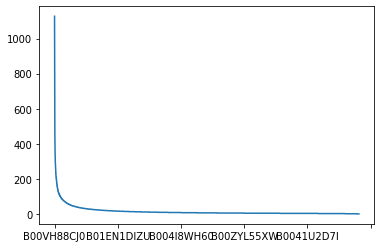

In [29]:
print('Distribution of number of reviews for each Item code:')
i['IC'].value_counts( sort=True).plot()


In [30]:
i['IC'].value_counts( sort=True)

B00VH88CJ0    1127
B005NF5NTK    1106
B019PV2I3G    1033
B00X5RV14Y    1018
B00P7N0320    1011
              ... 
B000VUNWV8       1
B01FLY0WBQ       1
B00B2HEQZK       1
B01B1Y2ED4       1
B018JYIUHS       1
Name: IC, Length: 48134, dtype: int64

In [31]:
i['IC'].value_counts( sort=True).describe()

count    48134.000000
mean        15.798604
std         34.904772
min          1.000000
25%          4.000000
50%          7.000000
75%         14.000000
max       1127.000000
Name: IC, dtype: float64

**Most of the Items (75%) have less than 14 reviews.**

---



## **Null values detection**
To find number of Items that do not have any review or review summary

In [32]:
tempdf = i[['IC', 'Rev_summ', 'Review']]

Creating 'Nulldetect' from 'tempdf' having 4 columns: 


1.   IC
2.   count: Number of reviews for each IC (This includes empty reviews too)
1.   sum: Null review + null rev_summ; Thus this column can have max value of 2 when both review and summary of review is not present.
2.   ratio: sum column normalised to count; Value of 2 : no review or rev_summ (all fields have null entry)




In [33]:
nulldetect = tempdf.set_index('IC').isnull().sum(axis=1).groupby(level=0).agg(['count','sum'])
nulldetect = pd.DataFrame(nulldetect)
nulldetect['ratio'] = nulldetect['sum']/nulldetect['count']
nulldetect = nulldetect.sort_values(by=['ratio'], ascending=False)
print("\'IC\' \'Number of reviews\' \'Total Null reviews and review summary\' \'fractio of null reviews\'")
nulldetect.head(10)


'IC' 'Number of reviews' 'Total Null reviews and review summary' 'fractio of null reviews'


,count,sum,ratio
IC,,,
B013UK9URK,1,2,2.000000
B00H8N7MU8,2,1,0.500000
B01EO2PONW,2,1,0.500000
B00AV114GW,2,1,0.500000
B017QCSG6E,4,2,0.500000
B017QWXHQ8,2,1,0.500000
B0195FBAP4,4,2,0.500000
B00FXQ40CA,2,1,0.500000
B00ULPH37M,3,1,0.333333


**Except for "B013UK9URK", all IC's have atleast one review and one summary for review**



---





In [34]:
frequency = pd.DataFrame(nulldetect['ratio'].value_counts())
frequency.sort_index(ascending=False)


,ratio
2.000000,1
0.500000,7
0.333333,22
0.285714,1
0.250000,25
...,...
0.001385,1
0.001353,1
0.001335,1
0.000904,1



---



# **Data selection for NLP model**

In [35]:
reviews.columns

Index(['Rating', 'Rev_verify', 'Review_Date', 'IC', 'Prod_meta',
       'Reviewer_Name', 'Review', 'Rev_summ', 'Review_timestamp', 'Useful',
       'Prod_img'],
      dtype='object')

**Idea behind column selection:**

1.   **Rating:** Ratings are not important for identification of key words. 
Using ratings will create a bias towards words from either high or low rating reviews.
2.   **Rev_verify:** Considering low amount of data per IC, Rev_verify was not selected for model. However, verified reviews could be given higher weightage than non verified.
1.   **Useful:** More importance is given to useful reviews as they helped other customer decide.
1.   **Review_Date:** Does not influence review unless a product had been modified.  
2.   **Prod_meta:** Does not influence review. However, sentiment for each feature in product meta data could be found. But that is not the problem statement.
1.   **Reviewer_Name:** Does not influence review.
2.   **Review and Rev_summ:** Required. Trivial.

1.   **Review_timestamp:** Does not influence review.
2.   **Prod_img:** Does not influence review.

In [36]:
reviews_data = reviews[['Rating', 'IC', 'Review', 'Rev_summ', 'Useful']]
reviews_data.head(2)

,Rating,IC,Review,Rev_summ,Useful
0,5,B009XD5TPQ,Bought it for my husband. He's very happy with it,He's very happy with,None
1,5,B016MF3P3K,Great screen protector. Doesn't even seem as ...,Five Stars,None


In [37]:
#"Useful" column has "None" values. Thus we replace them by 0.
reviews_data['Useful'] = reviews_data['Useful'].fillna(0)
reviews_data.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Rating,IC,Review,Rev_summ,Useful
0,5,B009XD5TPQ,Bought it for my husband. He's very happy with it,He's very happy with,0
1,5,B016MF3P3K,Great screen protector. Doesn't even seem as ...,Five Stars,0


**Using "useful" column:**

Useful score is important as it tells how useful the information in that particular review is.

---



1.   **weight of a word review** = (useful score)* (score for the word) / (median of useful score for the IC) *italicized text*



> However, to use this we need a non zero base value otherwise all reviews that did not get upvotes will be ignored.


2.   Thus 1 will be added to the useful column.




---



In [38]:
reviews_data['Useful'] = reviews_data['Useful'].replace(',','',regex=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
reviews_data['Useful'] = reviews_data['Useful'].fillna(0)
reviews_data['Useful'] = reviews_data['Useful'].astype(int) + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:

reviews_data['Useful'].describe()

count    760450.000000
mean          1.777457
std          10.054148
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1738.000000
Name: Useful, dtype: float64

In [41]:
k = reviews_data['Useful']

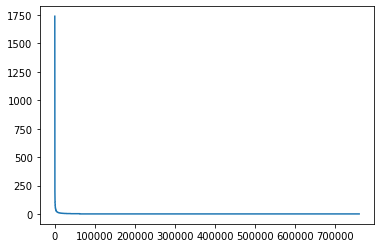

In [42]:
sortedk = sorted(k,reverse = True)
import matplotlib.pyplot as plt
plt.plot(sortedk)

In [43]:
dictionary = dict(tuple(i.groupby('IC')))

In [44]:
dictionary

{'7508492919':         Rating  Rev_verify  Review_Date  ... Review_timestamp Useful Prod_img
 27538        5        True  08 28, 2013  ...       1377648000   None     None
 27692        3        True   01 6, 2015  ...       1420502400   None     None
 36362        4        True  01 27, 2013  ...       1359244800   None     None
 78623        5        True  02 12, 2014  ...       1392163200   None     None
 89584        4        True   02 3, 2014  ...       1391385600   None     None
 99039        5        True   01 5, 2013  ...       1357344000   None     None
 128264       5        True   01 7, 2013  ...       1357516800   None     None
 171170       5        True  12 17, 2012  ...       1355702400   None     None
 213810       4       False  04 10, 2013  ...       1365552000   None     None
 230815       4        True  02 15, 2015  ...       1423958400   None     None
 241686       5        True  11 25, 2012  ...       1353801600   None     None
 250262       4        True  12 12, 20

In [45]:
i['IC'].value_counts( sort=True).mode()


0    4
dtype: int64

In [46]:
reviews.columns

Index(['Rating', 'Rev_verify', 'Review_Date', 'IC', 'Prod_meta',
       'Reviewer_Name', 'Review', 'Rev_summ', 'Review_timestamp', 'Useful',
       'Prod_img'],
      dtype='object')

In [47]:
i = reviews
df = i.drop(['Review_Date', 'Prod_meta', 'Reviewer_Name', 'Review_timestamp', 'Prod_img'] , axis = 1)
df.head()

,Rating,Rev_verify,IC,Review,Rev_summ,Useful
0,5,True,B009XD5TPQ,Bought it for my husband. He's very happy with it,He's very happy with,None
1,5,True,B016MF3P3K,Great screen protector. Doesn't even seem as ...,Five Stars,None
2,5,True,B008DC8N5G,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,None
3,3,True,B0089CH3TM,"The material and fit is very nice, but the col...",Good case overall,3
4,4,True,B00AKZWGAC,This last me about 3 days till i have to charg...,Awesome Battery,None


In [48]:
df.head()

,Rating,Rev_verify,IC,Review,Rev_summ,Useful
0,5,True,B009XD5TPQ,Bought it for my husband. He's very happy with it,He's very happy with,None
1,5,True,B016MF3P3K,Great screen protector. Doesn't even seem as ...,Five Stars,None
2,5,True,B008DC8N5G,Saved me lots of money! it's not gorilla glass...,As long as you know how to put it on!,None
3,3,True,B0089CH3TM,"The material and fit is very nice, but the col...",Good case overall,3
4,4,True,B00AKZWGAC,This last me about 3 days till i have to charg...,Awesome Battery,None


In [49]:
dictionary = dict(tuple(df.groupby('IC')))


In [50]:
dictionary

{'7508492919':         Rating  ...  Useful
 27538        5  ...    None
 27692        3  ...    None
 36362        4  ...    None
 78623        5  ...    None
 89584        4  ...    None
 99039        5  ...    None
 128264       5  ...    None
 171170       5  ...    None
 213810       4  ...    None
 230815       4  ...    None
 241686       5  ...    None
 250262       4  ...    None
 253135       5  ...    None
 302021       4  ...    None
 355071       5  ...    None
 365417       5  ...    None
 394145       5  ...    None
 404803       5  ...    None
 406270       4  ...    None
 436059       4  ...    None
 438115       5  ...    None
 438141       4  ...    None
 457632       5  ...    None
 476367       5  ...    None
 476987       3  ...    None
 498874       3  ...    None
 501954       5  ...    None
 537139       5  ...    None
 565616       5  ...    None
 573743       5  ...    None
 599626       2  ...    None
 600748       4  ...    None
 616578       5  ...    None


Trial

In [51]:
from gensim.summarization import keywords
dictionary['B001SIIKB4']

,Rating,Rev_verify,IC,Review,Rev_summ,Useful
151426,5,False,B001SIIKB4,I admit that this phone is inferior to many sm...,The best NON-SMART phone I have ever used,2
532480,5,True,B001SIIKB4,I LOVE this phone! I have had 2 and needing an...,Five Stars,None
646314,5,True,B001SIIKB4,muy bueno.,Five Stars,None
686006,5,True,B001SIIKB4,very good phone was more what I expected it ma...,very good,3
748111,5,True,B001SIIKB4,GREAT,Five Stars,None


In [52]:
dictionary['B001SIIKB4']['Useful'] = dictionary['B001SIIKB4']['Useful'].fillna(0)



In [53]:
dictionary['B001SIIKB4']['Useful'] = dictionary['B001SIIKB4']['Useful'].astype(int) + 1
dictionary['B001SIIKB4']

,Rating,Rev_verify,IC,Review,Rev_summ,Useful
151426,5,False,B001SIIKB4,I admit that this phone is inferior to many sm...,The best NON-SMART phone I have ever used,3
532480,5,True,B001SIIKB4,I LOVE this phone! I have had 2 and needing an...,Five Stars,1
646314,5,True,B001SIIKB4,muy bueno.,Five Stars,1
686006,5,True,B001SIIKB4,very good phone was more what I expected it ma...,very good,4
748111,5,True,B001SIIKB4,GREAT,Five Stars,1


In [54]:
dictionary['B001SIIKB4']['Useful_ratio'] = dictionary['B001SIIKB4']['Useful']//dictionary['B001SIIKB4']['Useful'].median()

In [55]:
dictionary['B001SIIKB4']['Useful_ratio'].astype(int)

151426    3
532480    1
646314    1
686006    4
748111    1
Name: Useful_ratio, dtype: int64

In [56]:
dictionary['B001SIIKB4']['Useful_ratio']


151426    3.0
532480    1.0
646314    1.0
686006    4.0
748111    1.0
Name: Useful_ratio, dtype: float64

In [57]:

dictionary['B001SIIKB4']['Useful_ratio'] = dictionary['B001SIIKB4']['Useful']//dictionary['B001SIIKB4']['Useful'].median()
dictionary['B001SIIKB4']['Useful_ratio'] = dictionary['B001SIIKB4']['Useful_ratio'].astype(int)
dictionary['B001SIIKB4']['Review'] = (dictionary['B001SIIKB4']['Review'] + " " )*(dictionary['B001SIIKB4']['Useful_ratio'])

In [58]:
dictionary['B001SIIKB4']

,Rating,Rev_verify,IC,Review,Rev_summ,Useful,Useful_ratio
151426,5,False,B001SIIKB4,I admit that this phone is inferior to many sm...,The best NON-SMART phone I have ever used,3,3
532480,5,True,B001SIIKB4,I LOVE this phone! I have had 2 and needing an...,Five Stars,1,1
646314,5,True,B001SIIKB4,muy bueno.,Five Stars,1,1
686006,5,True,B001SIIKB4,very good phone was more what I expected it ma...,very good,4,4
748111,5,True,B001SIIKB4,GREAT,Five Stars,1,1


# **Model**

In [59]:
dictionary = dict(tuple(i.groupby('IC')))


In [74]:
listIC = list(set(reviews_data['IC']))
len(listIC)

48134

In [62]:
from gensim.summarization import keywords
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [63]:
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lematise(text):
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    return(set(text))

In [84]:
data = {}
def final_file(IC):
  #dictionary[IC]['Useful'] = dictionary[IC]['Useful'].replace(',','',regex=True)
  #dictionary[IC]['Useful'] = dictionary[IC]['Useful'].fillna(0)
  #dictionary[IC]['Useful'] = dictionary[IC]['Useful'].astype(int) + 1
  #dictionary[IC]['Useful'][dictionary[IC]['Useful'] > 6] = 6
  #Generate weight from column "Useful"
  #dictionary[IC]['Useful_ratio'] = dictionary[IC]['Useful']//dictionary[IC]['Useful'].median()
  #dictionary[IC]['Useful_ratio'] = dictionary[IC]['Useful']
  #dictionary[IC]['Useful_ratio'] = dictionary[IC]['Useful_ratio'].astype(int)
  #dictionary[IC]['Review'] = (dictionary[IC]['Review'] + " " )*(dictionary[IC]['Useful_ratio'])
  #dictionary[IC]['Rev_summ'] = (dictionary[IC]['Rev_summ'] + " " )*(dictionary[IC]['Useful_ratio'])


  #combine all reviews and review summary for each Item code
  suma = ""
  for s in dictionary[IC]['Review']:

    s=str(s)
    suma = suma + " " + s
  for s in dictionary[IC]['Rev_summ']:
    s=str(s)
    suma = suma + " " + s
  #Generate final dataframe
  
  data[IC] = [dictionary[IC]['Rating'].max(), dictionary[IC]['Rating'].mean(), dictionary[IC]['Rating'].min(), [lematise(keywords(suma).split('\n'))]]

  return data

In [72]:
IC = ['B001GZO10I', 'B001H1JOKI']
for IC in IC:
  data = final_file(IC)

In [75]:
dat = pd.DataFrame(data).T
dat

,0,1,2,3
B001GZO10I,5,4.1,1,"[{screen, little, remain, minor, apple, overal..."
B001H1JOKI,5,4.5,4,"[{secure, great, nylon, velcro, belt, destruct..."


In [77]:
listIC

['B00X5C5JTC',
 'B01CA9WXJO',
 'B00ARBS3EC',
 'B00NLLCMDI',
 'B0048IZL5E',
 'B01774WPQ8',
 'B00WT3QBV8',
 'B0112S9SOC',
 'B01D7654UO',
 'B00OJETL3K',
 'B012XS63UM',
 'B00XVU4IPO',
 'B01FM3SRO0',
 'B01C5JGHZU',
 'B00Z8HN14C',
 'B009VB17DI',
 'B00JB0NZYI',
 'B00ORLA7TM',
 'B00ZPZARQW',
 'B0188FHCPE',
 'B0143LJNLS',
 'B00SG6SA1G',
 'B00ETOUNDC',
 'B00HDZUZ7I',
 'B000VMPWFA',
 'B01BXTVZR8',
 'B00EPMOIXE',
 'B00RMFGN34',
 'B00A6F31EQ',
 'B00N3BE9XM',
 'B00S5KE300',
 'B018FGWBQ6',
 'B00914WHD4',
 'B008OFCAQK',
 'B00A93UFU8',
 'B00ATZPDAS',
 'B019H38FSY',
 'B00QIHUXB0',
 'B013WGOI6K',
 'B01G8H8BPY',
 'B0094AT24C',
 'B01E35SACM',
 'B00ZV86D0C',
 'B00C57753G',
 'B013UOJYA4',
 'B01GOWODLO',
 'B0174KAC3S',
 'B006C9TI6K',
 'B00EYSA39W',
 'B00CRG2AGC',
 'B0153WTN66',
 'B007WHYPPU',
 'B010DJE9WC',
 'B00EOY1E4E',
 'B00GENM8TI',
 'B00739LP5K',
 'B01DGJPT5W',
 'B00A6V0LY8',
 'B00DHEHC3E',
 'B00907YCZ8',
 'B016ML1BK8',
 'B018A0VNNE',
 'B018Y19LN8',
 'B01AFXME9Q',
 'B00EVERJRI',
 'B00ZK4P2CC',
 'B00EKT8L

In [85]:
IC = listIC
i = 0
for IC in listIC:
  i = i +1
  print(IC, i)
  data = final_file(IC)

B00X5C5JTC 1
B01CA9WXJO 2
B00ARBS3EC 3
B00NLLCMDI 4
B0048IZL5E 5
B01774WPQ8 6
B00WT3QBV8 7
B0112S9SOC 8
B01D7654UO 9
B00OJETL3K 10
B012XS63UM 11
B00XVU4IPO 12
B01FM3SRO0 13
B01C5JGHZU 14
B00Z8HN14C 15
B009VB17DI 16
B00JB0NZYI 17
B00ORLA7TM 18
B00ZPZARQW 19
B0188FHCPE 20
B0143LJNLS 21
B00SG6SA1G 22
B00ETOUNDC 23
B00HDZUZ7I 24
B000VMPWFA 25
B01BXTVZR8 26
B00EPMOIXE 27
B00RMFGN34 28
B00A6F31EQ 29
B00N3BE9XM 30
B00S5KE300 31
B018FGWBQ6 32
B00914WHD4 33
B008OFCAQK 34
B00A93UFU8 35
B00ATZPDAS 36
B019H38FSY 37
B00QIHUXB0 38
B013WGOI6K 39
B01G8H8BPY 40
B0094AT24C 41
B01E35SACM 42
B00ZV86D0C 43
B00C57753G 44
B013UOJYA4 45
B01GOWODLO 46
B0174KAC3S 47
B006C9TI6K 48
B00EYSA39W 49
B00CRG2AGC 50
B0153WTN66 51
B007WHYPPU 52
B010DJE9WC 53
B00EOY1E4E 54
B00GENM8TI 55
B00739LP5K 56
B01DGJPT5W 57
B00A6V0LY8 58
B00DHEHC3E 59
B00907YCZ8 60
B016ML1BK8 61
B018A0VNNE 62
B018Y19LN8 63
B01AFXME9Q 64
B00EVERJRI 65
B00ZK4P2CC 66
B00EKT8LAS 67
B00U6QSNNO 68
B00TP8ZFHG 69
B00EMAF36U 70
B004WWLA38 71
B00E8CKG6Y 72
B

IndexError: ignored

In [86]:
dictionary['B00IWBVSGY']

,Rating,Rev_verify,Review_Date,IC,Prod_meta,Reviewer_Name,Review,Rev_summ,Review_timestamp,Useful,Prod_img
296812,2,True,"05 9, 2015",B00IWBVSGY,None,Tanmy R.,It do not served to my phone,Two Stars,1431129600,None,None
524424,5,True,"02 22, 2017",B00IWBVSGY,None,bajanrose,It did as was stated.,Five Stars,1487721600,None,None
679882,5,True,"01 23, 2017",B00IWBVSGY,None,Tristian Reid Lyons,Good and cheap,Five Stars,1485129600,None,None


In [88]:
final_file('B00IWBVSGY')

IndexError: ignored

In [89]:
data

{'B000VMPWFA': [5,
  4.32258064516129,
  3,
  [{'accept',
    'adapter',
    'buy',
    'camera',
    'charge',
    'china bulky',
    'compact',
    'contain',
    'croatia',
    'device',
    'different',
    'electric',
    'electrical',
    'electricity',
    'flimsy',
    'good quality',
    'great product',
    'half',
    'href',
    'iphone',
    'italy',
    'like',
    'likely',
    'plug',
    'power',
    'pressure applied',
    'prong',
    'properly',
    'star',
    'strip',
    'thanks',
    'travel',
    'tumi',
    'voltage',
    'work',
    'world'}]],
 'B002SP2XA0': [5,
  4.2,
  1,
  [{'amaze',
    'buena',
    'detail',
    'fast',
    'product',
    'replaceable',
    'replaced phone',
    'sin',
    'small'}]],
 'B003M2Y3UQ': [5,
  4.580645161290323,
  3,
  [{'accessory',
    'additional padding',
    'alittle',
    'amzer',
    'area',
    'awesome',
    'battery',
    'bit',
    'button',
    'camera',
    'case',
    'cheap',
    'cover',
    'covered',
    'd

In [91]:
database = pd.DataFrame(data)

In [95]:
database.to_csv('/content/drive/My Drive/keywords.csv', index=False)